Explanation for Grovers Algorithm

Overview of the notebook
1. Go over an what Grover's Algorithm is on a high level
2. Import Qiskit and other packages
3. Set up and plot the inital circuit
4. Define the Oracle
5. Apply the Oracle and plot how it changes the amplitudes and probabilies of the system
6. Define the Diffusion step
7. Apply Diffusion and plot how it changes the probabilites of the system
8. Calculate K, the amount of times to apply the Oracle and Diffusion
9. Apply the Oracle and Diffusion K times and plot the results
10. Run the same circuit on a real IBM quantum computer and plot results

THIS CELL IS TO BE DELETED

https://github.com/Qiskit/qiskit-tutorials
Example tutorials using juypter notebooks

Possible flow through the notebook
1. inital set up of quantum ciruit
2. Definition of the orcale
3. apply it once and show plot of what it change
4. definition of the difffusion step
5. apply it once and show plot of what it changes
6. calulate how many times the oracle and diffusion should be applied
7. apply it K - 1 times and show end result plot

GROVER OVERVIEW 
Imagine you are searching for a single correct item hidden somewhere in a huge, unsorted list.
On a classical computer, you would check items one by one.
On a quantum computer, Grover’s Algorithm lets you “look at all items at once” and gradually boost the chance of finding the correct one.
Grover’s Algorithm works in three main ideas:
Superposition – look everywhere at once
Oracle – recognize the correct answer
Amplitude Amplification – make the correct answer stand out
Superposition: Looking at All Possibilities at Once
A classical bit is either 0 or 1
A quantum bit (qubit) can be 0 or 1 or both at the same time (superposition)
When we use multiple qubits:
2 qubits → 4 possible states
3 qubits → 8 possible states
n qubits → 2ⁿ possible states
Grover’s Algorithm starts by putting the system into a superposition of all possible answers.
Oracle: Marking the Correct Answer
The oracle is a special quantum operation that recognizes the correct answer and “Marks” it without telling us what it is directly
Instead of pointing at the correct answer, the oracle flips the sign (phase) of the correct state’s amplitude
The oracle does not reveal the answer, it only tags the correct state so it can be amplified later

Amplitude Amplification: Making the Answer Stand Out
After marking the correct answer, Grover’s Algorithm boosts the probability of measuring it and shrinks the probabilities of all others. When we measure a system it collapses to one of the states and the probability of collapsing to each state is the amplitude squared so the higher the amplitude is the higher chance the system has to collapse to that state.
This is done through a clever “reflection” process which is repeated multiple times:
Reflect amplitudes around their average
The marked state grows larger each time
Others shrink slightly

After enough repetitions the correct answer is much more likely to be measured so measuring the system gives the right answer with high probability
Why Grover’s Algorithm Is Powerful
For an unsorted list of length N  instead of a classic search algorithm taking O(N) to search through it Grover’s Algorithm takes ~O(√N) 


To run Grover's Algorithm we will first go through running it on Qiskit's AER simulator then we will go through how to run in on one of IBM's quantum computers

Lets start by importing qiskit

In [1]:
import qiskit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_city
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



Next we will define the target bit string we are trying to find and set up the beginings of our ciruit

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


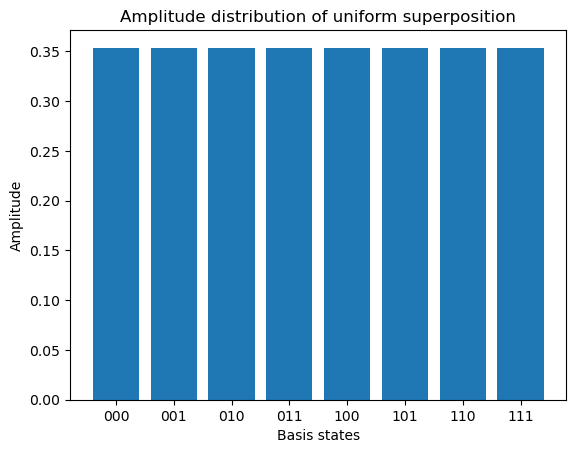

In [2]:
target = "100"
n = len(target)
target = target[::-1] # reverse the bit string

cir = qiskit.QuantumCircuit(n)

# put the ciruit in a superpositon of all possible states
cir.h(range(n))

# plot the current amplitudes
cir.save_statevector()
sim = AerSimulator(method="statevector")
result = sim.run(cir).result()
state = result.get_statevector()
labels = [format(i, f'0{n}b') for i in range(2**n)]

plt.bar(labels, state)
plt.xlabel("Basis states")
plt.ylabel("Amplitude")
plt.title("Amplitude distribution of uniform superposition")
plt.show()


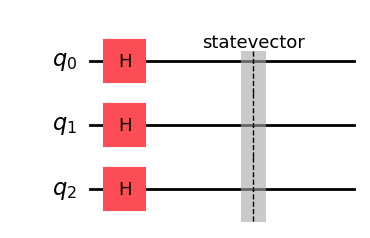

In [3]:
#Optional draw the circuit
fig = (cir.draw(output="mpl"))
plt.show(fig)

Then we will define the Oracle
The Oracle is a special quantum operation that:
Knows how to recognize the correct answer
Marks it by flipping its phase

In [4]:
# The circuit is in a superposition of all states 
# before being passed to Oracle
def Oracle(circuit):
    # change the target state to be all '1's
    for i in range (n): 
        if target[i] == '0':
            circuit.x(i)

    # does a phase flip on the '111' state to change
    # its amplidute to be negative
    circuit.h(n-1) 
    circuit.mcx(list(range(n-1)), n-1)
    circuit.h(n-1)

    # undoes the change from the first loop
    # now the target state has negative aplitude 
    # and is "marked" which is what we want
    for i in range (n):
        if target[i] == '0':
            circuit.x(i)


Lets create the ciruit again and apply the oracle to see what changes

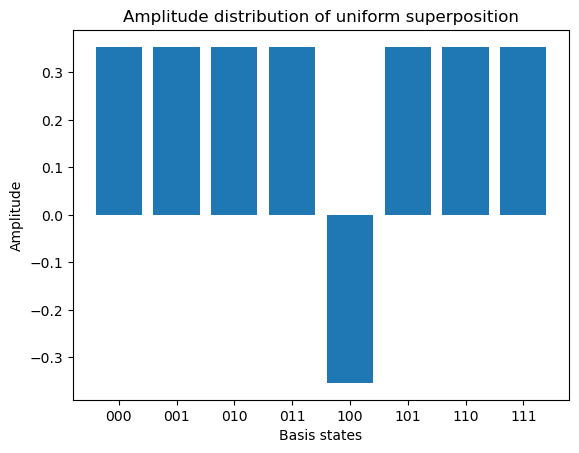

In [5]:
cir = qiskit.QuantumCircuit(n)
# put the ciruit in a superpositon of all possible states
cir.h(range(n))
# Apply the Oracle
Oracle(cir)

# plot the current amplitudes
cir.save_statevector()
sim = AerSimulator(method="statevector")
result = sim.run(cir).result()
state = result.get_statevector()
labels = [format(i, f'0{n}b') for i in range(2**n)]

plt.bar(labels, state)
plt.xlabel("Basis states")
plt.ylabel("Amplitude")
plt.title("Amplitude distribution of uniform superposition")
plt.show()

As we can see, only the amplitude of the target state is changed and specifically it is fliped to be negative now. 
Lets also plot the probablities to use for compairison later

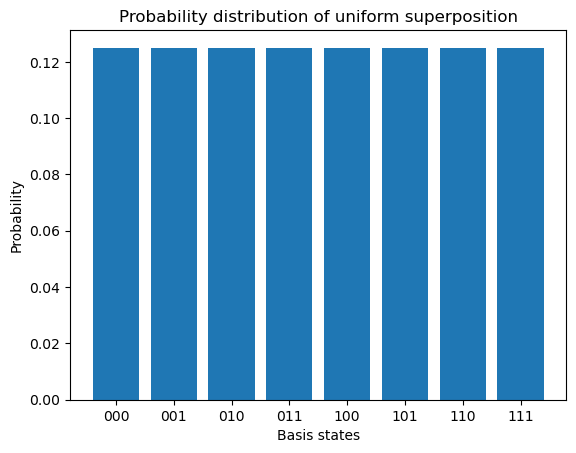

In [6]:
labels = [format(i, f'0{n}b') for i in range(2**n)]
probs = np.abs(state) ** 2
plt.bar(labels, probs)
plt.xlabel("Basis states")
plt.ylabel("Probability")
plt.title("Probability distribution of uniform superposition")
plt.show()

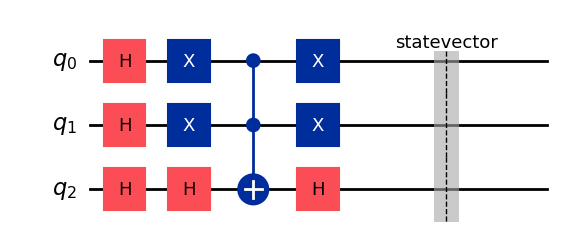

In [7]:
#Optional draw the circuit
fig = (cir.draw(output="mpl"))
plt.show(fig)

Next we will define the Diffusion step

In [8]:
def Diffusion(circuit):
    #convert back to the original basis
    for i in range (n):
        circuit.h(i)

    #flip all the qbits
    for i in range (n):
        circuit.x(i)

    # flips the phase of the "1111" state
    circuit.h(n-1)
    circuit.mcx(list(range(n-1)), n-1)
    circuit.h(n-1)

    #return circuit to correct basis
    for i in range (n):
        circuit.x(i)
    for i in range (n):
        circuit.h(i)

Once again we will recreate the circuit and plot how it changes after the diffusion step has been applied. 

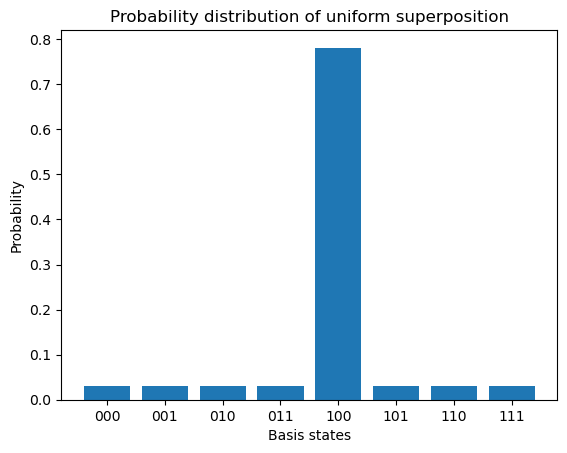

In [9]:
cir = qiskit.QuantumCircuit(n)
# put the ciruit in a superpositon of all possible states
cir.h(range(n))
Oracle(cir)
Diffusion (cir)

# plot the current amplitudes
cir.save_statevector()
sim = AerSimulator(method="statevector")
result = sim.run(cir).result()
state = result.get_statevector()
labels = [format(i, f'0{n}b') for i in range(2**n)]
probs = np.abs(state) ** 2

plt.bar(labels, probs)
plt.xlabel("Basis states")
plt.ylabel("Probability")
plt.title("Probability distribution of uniform superposition")
plt.show()

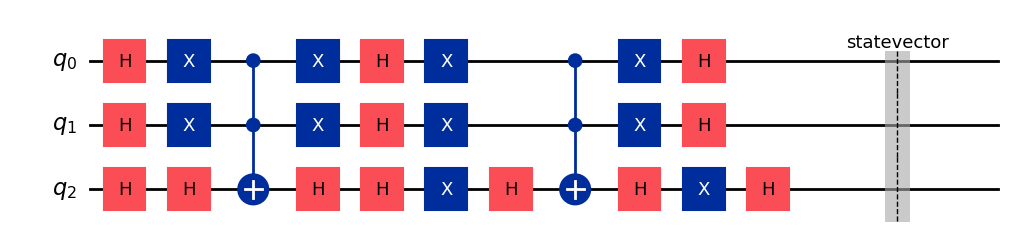

In [10]:
#Optional draw the circuit
fig = (cir.draw(output="mpl"))
plt.show(fig)

As we can see, the probability of the target state went up by a lot while the probabliy of the other states went down

In Grover's Algorithm, you usually repeat the process of applying the Oracle then diffusion step more than once
Lets calculate K, the amount of times to apply the 2 processes

In [11]:
K = int(np.floor(np.pi / 4 * np.sqrt(2 ** n)))
print("K: ", K)

K:  2


Lets create the ciruit one last time and then plot the ending probabilities

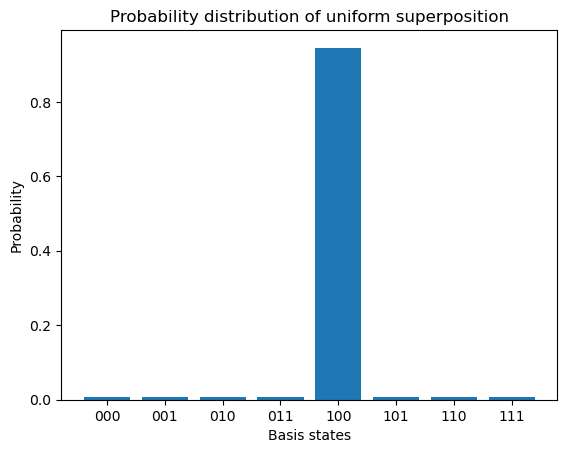

In [12]:
cir = qiskit.QuantumCircuit(n)
cir.h(range(n)) 
for _ in range(K):
    Oracle(cir)
    Diffusion(cir)
cir.save_statevector()
sim = AerSimulator(method="statevector")
result = sim.run(cir).result()
state = result.get_statevector()

labels = [format(i, f'0{n}b') for i in range(2**n)]
probs = np.abs(state) ** 2
plt.bar(labels, probs)
plt.xlabel("Basis states")
plt.ylabel("Probability")
plt.title("Probability distribution of uniform superposition")
plt.show()

The probabilty of measuring the target state is even higher now and we should feel pretty confident that we would get the correct result

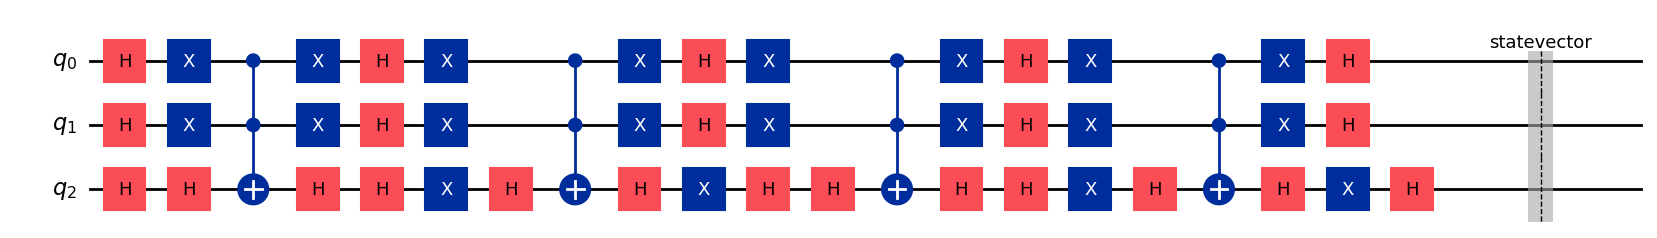

In [13]:
#Optional draw the circuit
fig = (cir.draw(output="mpl"))
plt.show(fig)

Now lets try to run the same quantum circuit on a real IBM quantum computer

In [14]:
#Initial set up imports
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

In [15]:
#Link your IBM account
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token= "gX06pQc4pj7AZk7DHIWM_Ye3pzXUvqr9z7SEST5W-FMm",
    #token="PASTE API TOKEN HERE",
    overwrite=True 
)

In [16]:
# Set up target and Quantum Circuit
target = "101"
target = target[::-1]
n = len(target)

qc = QuantumCircuit(n)
qc.h(range(n))

In [17]:
#Define the Oracle for a real Quantum Computer
def Oracle_Real(circuit):
    for i in range(n):
        if target[i] == "0":
            circuit.x(i)
    circuit.h(n-1)
    circuit.mcx(list(range(n-1)), n-1)
    circuit.h(n-1)
    for i in range(n):
        if target[i] == "0":
            circuit.x(i)


In [18]:
#Define Diffusion for a real Quantum Computer
def Diffusion_Real(circuit):
    for i in range(n):
        circuit.h(i)
    for i in range(n):
        circuit.x(i)
    circuit.h(n-1)
    circuit.mcx(list(range(n-1)), n-1)
    circuit.h(n-1)
    for i in range(n):
        circuit.x(i)
    for i in range(n):
        circuit.h(i)


In [19]:
# Apply the Oracle and Diffusion step K times
k = int(np.floor(np.pi / 4 * np.sqrt(2 ** n)))
for _ in range(k):
    Oracle_Real(qc)
    Diffusion_Real(qc)

#measure the results
qc.measure_all()

Now lets find a IBM backend to run the circuit on

In [20]:
service = QiskitRuntimeService()

backend = service.least_busy(
    operational=True,
    simulator=False,
    min_num_qubits=n
)
print("Running on:", backend.name)


Running on: ibm_torino


Now that we have our backend lets run the circuit and see what the probabilites look like

Job ID: <bound method BasePrimitiveJob.job_id of <RuntimeJobV2('d5p8h9e5v3os73f1m5kg', 'sampler')>>
Measurement counts:  {'101': 817, '001': 57, '011': 28, '111': 19, '000': 35, '100': 27, '110': 26, '010': 15}


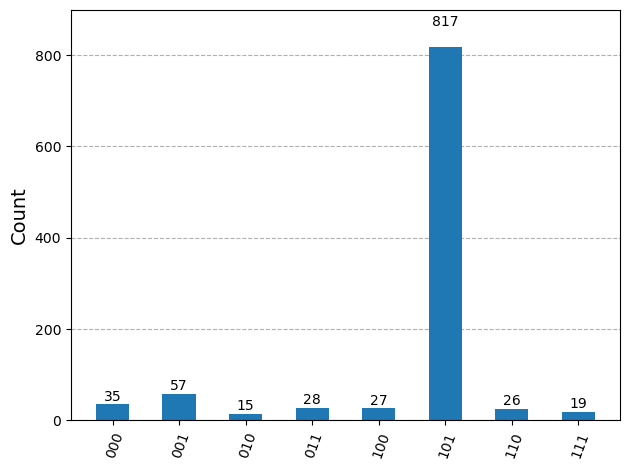

In [21]:
qc_transpiled = transpile(qc, backend=backend, optimization_level=3)

sampler = SamplerV2(mode=backend)

# Submit the job and get results
job = sampler.run([qc_transpiled], shots=1024)
print(f"Job ID: {job.job_id}")
result = job.result()
counts = result[0].data.meas.get_counts()
print(f"Measurement counts: ", counts)


plot_histogram(counts)
plt.show()

As we can see the probablity of our target state is still much higher than the rest of the states. 
Unlike with the AER simulator however, the other state probabilites are a little higher and more random. This is due to the fact that real quantum computers have noice or interference that changes the probabilites.